In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

from scripts_ml.ann_utils import *

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 204129632175073669
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13302214720821833358
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15385299073310540440
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 24199030375
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13691736373586337255
physical_device_desc: "device: 0, name: Quadro P6000, pci bus id: 0000:00:05.0, compute capability: 6.1"
]


In [3]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-04-30_p90_bg_'
valid_code = '_val_26000_2000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190824_1722'
postfix_time_seq = '_190824_1230'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = "MLP_"+preproc_folder+valid_code.split('_val_')[1][:-1]+"_opt_p90"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [4]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Flatten, GRU
from tensorflow.keras.models import Sequential

In [5]:
#recombining folds for grid search

val_X_all = []
val_y_all = []
indexes_tuples = []

count=0
start_tr=0

for idx in indexes:
    val_X_all.append(list(val_X_train[idx[0]]))
    val_y_all.append(list(val_y_train[idx[0]]))
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    #val_X_all.append(list(val_X_test[test_idx]))
    #val_y_all.append(list(val_y_test[test_idx]))
    
    
    if count==0:
        start_tst = len(idx[0])
    else:
        start_tr+=add_to_tr
        start_tst=start_tr+len(idx[0])
        
    indexes_tuples.append((np.array(range(start_tr, start_tr+len(idx[0]))), 
                          np.array(range(start_tst, start_tst+len(idx[1])))))
    
    add_to_tr = len(idx[0])+len(idx[1])
    
    count+=1

In [6]:
np.array(val_X_all[1:]).shape

(9, 26000, 35)

In [7]:
X = np.array(val_X_all[1:]).reshape((26000,9,35))
#y = np.array([val_X_all[1]])
X.shape

(26000, 9, 35)

In [8]:
y = np.array(val_y_all[1:]).reshape((26000,9,1))
y.shape

(26000, 9, 1)

In [387]:
model = Sequential()

#model.add(LSTM(80, return_sequences=True,  dropout=0.1))#, recurrent_dropout=0.2)) #, dropout=0.1, recurrent_dropout=0.1)) #, dropout=0.1, recurrent_dropout=0.1))
#model.add(LSTM(40, return_sequences=True,  dropout=0.1, activation='relu'))#, recurrent_dropout=0.2))
#model.add(LSTM(20, return_sequences=True,  dropout=0.1, activation='relu'))
#model.add(LSTM(10, return_sequences=True,  dropout=0.1))

model.add(GRU(80, return_sequences=True,  dropout=0.1))#, recurrent_dropout=0.2)) #, dropout=0.1, recurrent_dropout=0.1)) #, dropout=0.1, recurrent_dropout=0.1))
model.add(GRU(40, return_sequences=True,  dropout=0.1, activation='relu'))#, recurrent_dropout=0.2))
model.add(GRU(20, return_sequences=True,  dropout=0.1, activation='relu'))
model.add(GRU(10, return_sequences=True,  dropout=0.1))

model.add(Dense(1, activation='sigmoid'))
model.compile( optimizer='adam', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()])
#             sample_weight_mode='temporal')

In [388]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [389]:
cw = class_weight.compute_sample_weight({0:1, 1:50},#'balanced',
                                                 #np.unique(y_train),
                                                 y.flatten())

In [390]:
with tf.device("/device:GPU:0"):
    model.fit(X, y, epochs=500, batch_size=4096, verbose=1) #, validation_split=0.2) #, class_weight=cw.reshape(26000,9,1)) #, sample_weight=yy)

Epoch 1/500
26000/26000 [==============================] - 4s 171us/sample - loss: 0.6621 - acc: 0.6723 - auc_44: 0.5215
Epoch 2/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.5525 - acc: 0.8725 - auc_44: 0.5174
Epoch 3/500
26000/26000 [==============================] - 1s 36us/sample - loss: 0.4410 - acc: 0.9105 - auc_44: 0.5263
Epoch 4/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.3634 - acc: 0.9169 - auc_44: 0.5356
Epoch 5/500
26000/26000 [==============================] - 1s 36us/sample - loss: 0.3296 - acc: 0.9174 - auc_44: 0.5440
Epoch 6/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.3148 - acc: 0.9175 - auc_44: 0.5553
Epoch 7/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.3059 - acc: 0.9175 - auc_44: 0.5748
Epoch 8/500
26000/26000 [==============================] - 1s 36us/sample - loss: 0.2975 - acc: 0.9162 - auc_44: 0.6186
Epoch 9/500
26000/26000 [==============

26000/26000 [==============================] - 1s 36us/sample - loss: 0.1275 - acc: 0.9539 - auc_44: 0.9503
Epoch 69/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.1275 - acc: 0.9543 - auc_44: 0.9502
Epoch 70/500
26000/26000 [==============================] - 1s 38us/sample - loss: 0.1260 - acc: 0.9550 - auc_44: 0.9511
Epoch 71/500
26000/26000 [==============================] - 1s 36us/sample - loss: 0.1258 - acc: 0.9541 - auc_44: 0.9513
Epoch 72/500
26000/26000 [==============================] - 1s 36us/sample - loss: 0.1243 - acc: 0.9546 - auc_44: 0.9523
Epoch 73/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.1230 - acc: 0.9557 - auc_44: 0.9535
Epoch 74/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.1229 - acc: 0.9554 - auc_44: 0.9526
Epoch 75/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.1220 - acc: 0.9555 - auc_44: 0.9542
Epoch 76/500
26000/26000 [===================

26000/26000 [==============================] - 1s 36us/sample - loss: 0.0919 - acc: 0.9655 - auc_44: 0.9736
Epoch 136/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0911 - acc: 0.9658 - auc_44: 0.9746
Epoch 137/500
26000/26000 [==============================] - 1s 36us/sample - loss: 0.0912 - acc: 0.9657 - auc_44: 0.9738
Epoch 138/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0893 - acc: 0.9662 - auc_44: 0.9750
Epoch 139/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0896 - acc: 0.9664 - auc_44: 0.9747
Epoch 140/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0899 - acc: 0.9661 - auc_44: 0.9747
Epoch 141/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0885 - acc: 0.9664 - auc_44: 0.9755
Epoch 142/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0886 - acc: 0.9667 - auc_44: 0.9750
Epoch 143/500
26000/26000 [===========

26000/26000 [==============================] - 1s 36us/sample - loss: 0.0724 - acc: 0.9729 - auc_44: 0.9823
Epoch 203/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0735 - acc: 0.9722 - auc_44: 0.9820
Epoch 204/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0721 - acc: 0.9725 - auc_44: 0.9825
Epoch 205/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0725 - acc: 0.9729 - auc_44: 0.9815
Epoch 206/500
26000/26000 [==============================] - 1s 33us/sample - loss: 0.0717 - acc: 0.9731 - auc_44: 0.9826
Epoch 207/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0725 - acc: 0.9725 - auc_44: 0.9821
Epoch 208/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0714 - acc: 0.9733 - auc_44: 0.9825
Epoch 209/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0720 - acc: 0.9727 - auc_44: 0.9819
Epoch 210/500
26000/26000 [===========

26000/26000 [==============================] - 1s 35us/sample - loss: 0.0623 - acc: 0.9769 - auc_44: 0.9859
Epoch 270/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0613 - acc: 0.9772 - auc_44: 0.9864
Epoch 271/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0618 - acc: 0.9771 - auc_44: 0.9864
Epoch 272/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0625 - acc: 0.9764 - auc_44: 0.9861
Epoch 273/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0618 - acc: 0.9769 - auc_44: 0.9866
Epoch 274/500
26000/26000 [==============================] - 1s 33us/sample - loss: 0.0614 - acc: 0.9771 - auc_44: 0.9860
Epoch 275/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0608 - acc: 0.9773 - auc_44: 0.9866
Epoch 276/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0610 - acc: 0.9774 - auc_44: 0.9865
Epoch 277/500
26000/26000 [===========

26000/26000 [==============================] - 1s 37us/sample - loss: 0.0547 - acc: 0.9795 - auc_44: 0.9889
Epoch 337/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0537 - acc: 0.9797 - auc_44: 0.9895
Epoch 338/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0552 - acc: 0.9791 - auc_44: 0.9888
Epoch 339/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0540 - acc: 0.9798 - auc_44: 0.9888
Epoch 340/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0545 - acc: 0.9798 - auc_44: 0.9889
Epoch 341/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0535 - acc: 0.9803 - auc_44: 0.9896
Epoch 342/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0537 - acc: 0.9798 - auc_44: 0.9892
Epoch 343/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0538 - acc: 0.9798 - auc_44: 0.9896
Epoch 344/500
26000/26000 [===========

26000/26000 [==============================] - 1s 37us/sample - loss: 0.0492 - acc: 0.9819 - auc_44: 0.9907
Epoch 404/500
26000/26000 [==============================] - 1s 33us/sample - loss: 0.0488 - acc: 0.9818 - auc_44: 0.9908
Epoch 405/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0479 - acc: 0.9821 - auc_44: 0.9917
Epoch 406/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0482 - acc: 0.9822 - auc_44: 0.9915
Epoch 407/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0482 - acc: 0.9822 - auc_44: 0.9910
Epoch 408/500
26000/26000 [==============================] - 1s 33us/sample - loss: 0.0486 - acc: 0.9820 - auc_44: 0.9908
Epoch 409/500
26000/26000 [==============================] - 1s 37us/sample - loss: 0.0478 - acc: 0.9822 - auc_44: 0.9915
Epoch 410/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0483 - acc: 0.9821 - auc_44: 0.9913
Epoch 411/500
26000/26000 [===========

26000/26000 [==============================] - 1s 36us/sample - loss: 0.0442 - acc: 0.9835 - auc_44: 0.9926
Epoch 471/500
26000/26000 [==============================] - 1s 36us/sample - loss: 0.0443 - acc: 0.9834 - auc_44: 0.9928
Epoch 472/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0442 - acc: 0.9832 - auc_44: 0.9929
Epoch 473/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0449 - acc: 0.9834 - auc_44: 0.9921
Epoch 474/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0445 - acc: 0.9835 - auc_44: 0.9923
Epoch 475/500
26000/26000 [==============================] - 1s 35us/sample - loss: 0.0438 - acc: 0.9839 - auc_44: 0.9930
Epoch 476/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0445 - acc: 0.9833 - auc_44: 0.9926
Epoch 477/500
26000/26000 [==============================] - 1s 34us/sample - loss: 0.0441 - acc: 0.9837 - auc_44: 0.9926
Epoch 478/500
26000/26000 [===========

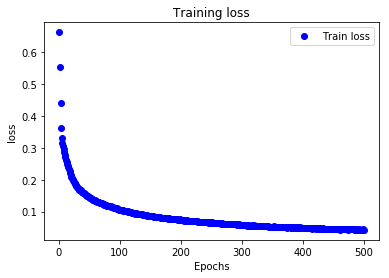

In [391]:
history = model.history.history
plot_epochs_graph(history, 'loss', False)

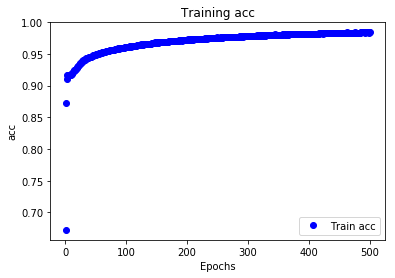

In [392]:
plot_epochs_graph(history, 'acc', False)

In [393]:
plot_epochs_graph(history, 'auc_43', False)

KeyError: 'auc_43'

In [394]:
y_scores = model.predict(X_test.reshape(11518,1,35))

In [395]:
y_scores = y_scores.flatten()

In [396]:
X_test.shape

(11518, 35)

In [397]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc=roc_auc_score(y_test, y_scores)
print("AUC {:.3f}".format(auc))

AUC 0.754
